In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
import os
from PIL import Image
from tqdm import tqdm
from glob import glob


import tensorflow as tf
from tensorflow.keras.layers import Conv2D , MaxPooling2D , BatchNormalization , Conv2DTranspose , Concatenate ,  Input
from tensorflow.keras.models import Sequential , Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import warnings
warnings.filterwarnings('ignore')

2025-08-06 14:19:19.518422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754489959.886766      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754489959.991434      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
root = "/kaggle/input/lgg-mri-segmentation/kaggle_3m"

In [3]:
def create_data(path_data):
    images_paths = []
    masks_paths = glob(f'{path_data}/*/*_mask*')

    for i in masks_paths:
        images_paths.append(i.replace('_mask',''))

    return images_paths , masks_paths

In [4]:
images , masks = create_data(root)

In [5]:
print("images_len: ", len(images))
print("masks_len: ", len(masks))

images_len:  3929
masks_len:  3929


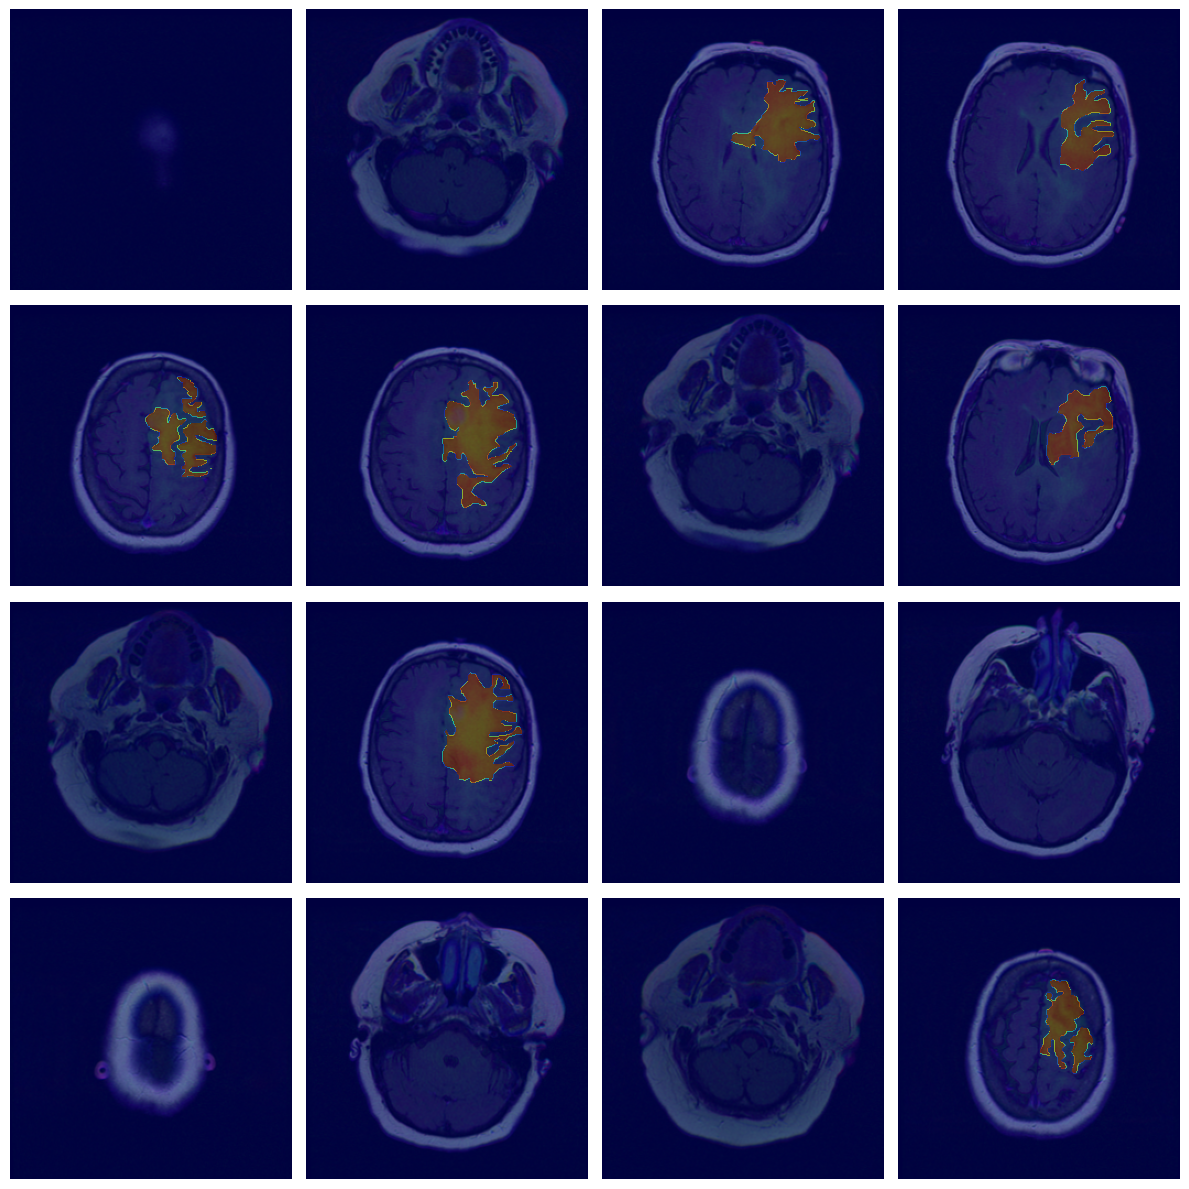

In [6]:
plt.figure(figsize = (12 , 12))
for i in range(16):
    plt.subplot(4 , 4 , i+1)

    image = images[i]
    mask = masks[i]

    img = cv.imread(image)
    img = cv.cvtColor(img , cv.COLOR_BGR2RGB)

    mask = cv.imread(mask , cv.IMREAD_GRAYSCALE)

    plt.imshow(img)
    plt.imshow(mask , cmap = 'jet' , alpha = 0.5)
    plt.axis('off')
plt.tight_layout()
plt.show() 

In [7]:
H = 256
W = 256
C = 3

In [8]:
def preprocessing_data():
    images_list = []
    masks_list = []

    for img_path, mask_path in zip(images, masks):
        img = cv.imread(img_path, cv.IMREAD_COLOR)
        mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)

        if img is None or mask is None:
            print(f"Failed to load image or mask: {img_path} : {mask_path}")
            continue

        img = cv.resize(img, (H, W))
        mask = cv.resize(mask, (H, W))
        img = img/255.0
        mask = mask/255.0

        images_list.append(img)
        masks_list.append(mask)

    if not images_list:
        raise ValueError("No images or masks were loaded. Check file paths.")

    images_array = np.array(images_list)
    masks_array = np.array(masks_list)

    masks_array = np.expand_dims(masks_array, axis=-1)

    return images_array, masks_array

In [9]:
images, masks = preprocessing_data()

In [10]:
print('The Shape of X',images.shape)
print('The Shape of y',masks.shape)

The Shape of X (3929, 256, 256, 3)
The Shape of y (3929, 256, 256, 1)


In [11]:
images = np.array(images , dtype = np.float32)
masks = np.array(masks , dtype = np.float32)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=0)

print('The shape of X_train',X_train.shape)
print('The shape of y_train',y_train.shape)
print('The shape of X_test',X_test.shape)
print('The shape of y_test',y_test.shape)

The shape of X_train (3143, 256, 256, 3)
The shape of y_train (3143, 256, 256, 1)
The shape of X_test (786, 256, 256, 3)
The shape of y_test (786, 256, 256, 1)


In [13]:
def build_unet(input_shape = (H , W , C)):
    inputs = Input(input_shape)
    # Encoder
    e1 = Conv2D(32 , (3,3) , activation = 'relu' , padding = 'same')(inputs)
    e1 = BatchNormalization()(e1)
    e1 = Conv2D(32 , (3,3) , activation = 'relu' , padding = 'same')(e1)
    e1 = BatchNormalization()(e1)
    p1 = MaxPooling2D((2,2))(e1)

    e2 = Conv2D(64 , (3,3) , activation = 'relu' , padding = 'same')(p1)
    e2 = BatchNormalization()(e2)
    e2 = Conv2D(64 , (3,3) , activation = 'relu' , padding = 'same')(e2)
    e2 = BatchNormalization()(e2)
    p2 = MaxPooling2D((2,2))(e2)

    e3 = Conv2D(128 , (3,3) , activation = 'relu' , padding = 'same')(p2)
    e3 = BatchNormalization()(e3)
    e3 = Conv2D(128 , (3,3) , activation = 'relu' , padding = 'same')(e3)
    e3 = BatchNormalization()(e3)
    p3 = MaxPooling2D((2,2))(e3)

    e4 = Conv2D(256 , (3,3) , activation = 'relu' , padding = 'same')(p3)
    e4 = BatchNormalization()(e4)
    e4 = Conv2D(256 , (3,3) , activation = 'relu' , padding = 'same')(e4)
    e4 = BatchNormalization()(e4)
    p4 = MaxPooling2D((2,2))(e4)

    # BottelNeck
    b1 = Conv2D(512 , (3,3) , activation = 'relu' , padding = 'same')(p4)
    b1 = BatchNormalization()(b1)
    b1 = Conv2D(512 , (3,3) , activation = 'relu' , padding = 'same')(b1)
    b1 = BatchNormalization()(b1)

    # Decoder
    d1 = Conv2DTranspose(256 , (2,2) , strides = (2,2), activation = 'relu' , padding = 'same')(b1)
    d1 = Concatenate()([d1 , e4])
    d1 = Conv2D(256 , (3,3) , activation = 'relu' , padding = 'same')(d1)
    d1 = BatchNormalization()(d1)
    d1 = Conv2D(256 , (3,3) , activation = 'relu' , padding = 'same')(d1)
    d1 = BatchNormalization()(d1)

    d2 = Conv2DTranspose(128 , (2,2) , strides = (2,2) , activation = 'relu' , padding = 'same')(d1)
    d2 = Concatenate()([d2 , e3])
    d2 = Conv2D(128 , (3,3) , activation = 'relu' , padding = 'same')(d2)
    d2 = BatchNormalization()(d2)
    d2 = Conv2D(128 , (3,3) , activation = 'relu' , padding = 'same')(d2)
    d2 = BatchNormalization()(d2)

    d3 = Conv2DTranspose(64 , (2,2) , strides = (2,2) , activation = 'relu' , padding = 'same')(d2)
    d3 = Concatenate()([d3 , e2])
    d3 = Conv2D(64 , (3,3) , activation = 'relu' , padding = 'same')(d3)
    d3 = BatchNormalization()(d3)
    d3 = Conv2D(64 , (3,3) , activation = 'relu' , padding = 'same')(d3)
    d3 = BatchNormalization()(d3)

    d4 = Conv2DTranspose(32 , (2,2) , strides = (2,2) , activation = 'relu' , padding = 'same')(d3)
    d4 = Concatenate()([d4 , e1])
    d4 = Conv2D(32 , (3,3) , activation = 'relu' , padding = 'same')(d4)
    d4 = BatchNormalization()(d4)
    d4 = Conv2D(32 , (3,3) , activation = 'relu' , padding = 'same')(d4)
    d4 = BatchNormalization()(d4)

    outputs = Conv2D(1 , (1,1) , activation = 'sigmoid')(d4)

    model = Model(inputs , outputs)

    return model

In [14]:
model = build_unet(input_shape=(H , W , C))

I0000 00:00:1754490063.052863      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754490063.053547      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [15]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-5)

model.compile(optimizer = optimizer, loss='binary_crossentropy' , metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(monitor = 'val_loss', patience = 10)

In [17]:
history = model.fit(
    X_train, y_train,
    epochs = 20,
    batch_size = 32,
    validation_data = (X_test, y_test),
    callbacks = [earlystopping]
)

Epoch 1/20


I0000 00:00:1754490089.985651     102 service.cc:148] XLA service 0x797940003b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754490089.987154     102 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754490089.987174     102 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754490091.797598     102 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-08-06 14:22:03.753023: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,256,256]{3,2,1,0}, f32[32,32,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_qu

98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 0.4630 - loss: 0.8560

E0000 00:00:1754490224.984024     103 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1754490225.217729     103 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


99/99 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.4633 - loss: 0.8553 - val_accuracy: 0.6869 - val_loss: 0.6790
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 73s 737ms/step - accuracy: 0.5264 - loss: 0.7543 - val_accuracy: 0.5399 - val_loss: 0.6960
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 74s 743ms/step - accuracy: 0.5817 - loss: 0.7130 - val_accuracy: 0.4814 - val_loss: 0.7066
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 73s 737ms/step - accuracy: 0.6507 - loss: 0.6806 - val_accuracy: 0.5925 - val_loss: 0.6806
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 73s 739ms/step - accuracy: 0.7153 - loss: 0.6554 - val_accuracy: 0.7248 - val_loss: 0.6323
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 73s 741ms/step - accuracy: 0.7745 - loss: 0.6338 - val_accuracy: 0.9009 - val_loss: 0.5446
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 73s 742ms/step - accuracy: 0.8172 - loss: 0.6139 - val_accuracy: 0.9271 - val_loss: 0.5188
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 73s 741ms/step - accuracy: 0.8604 - loss: 0.5909 - val_accuracy: 0.9322 

In [18]:
loss , accuarcy = model.evaluate(X_test , y_test)
print(f"The Loss : {loss}")
print(f"The accuarcy : {accuarcy}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.9894 - loss: 0.4844
The Loss : 0.4836702346801758
The accuarcy : 0.9894919395446777


In [19]:
predict_mask = model.predict(X_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 272ms/step


In [20]:
predict_mask = (predict_mask > 0.5).astype(np.uint8)

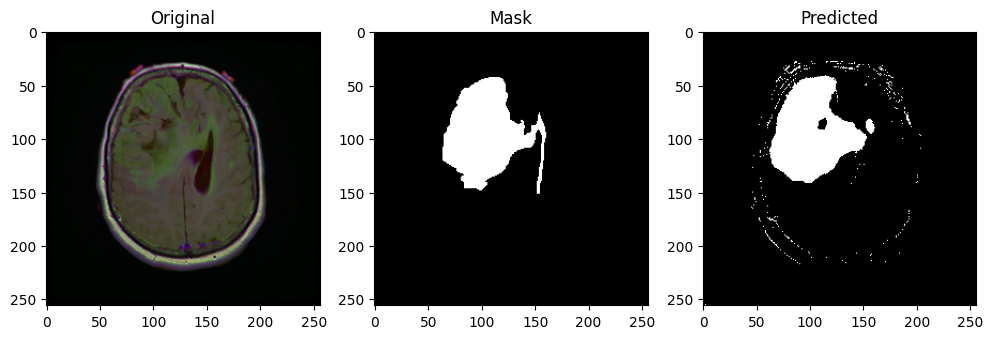

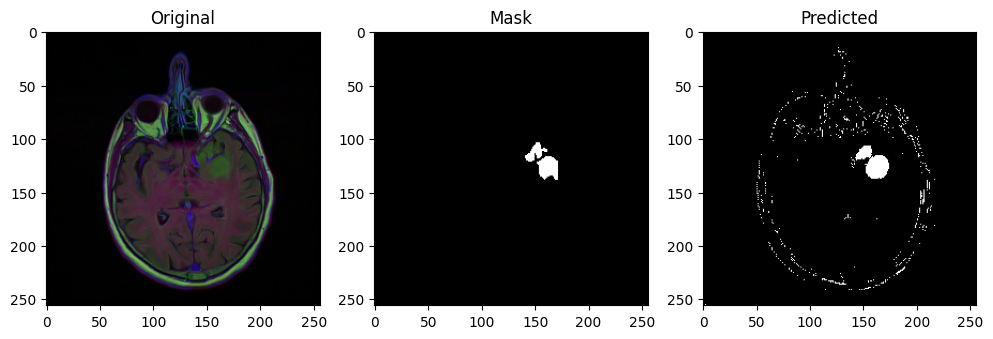

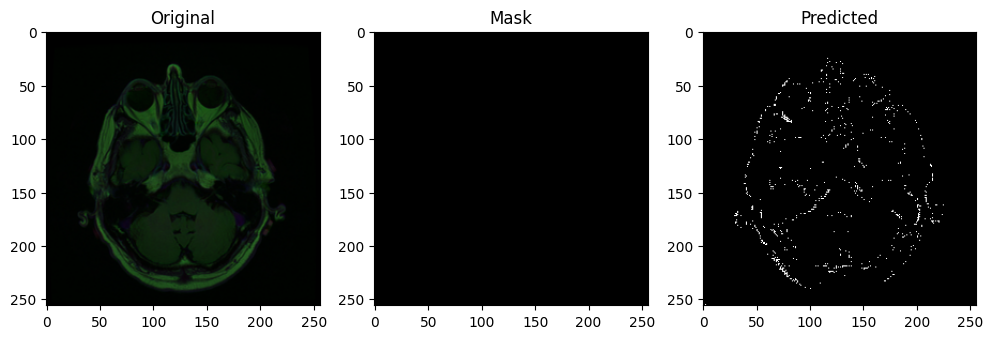

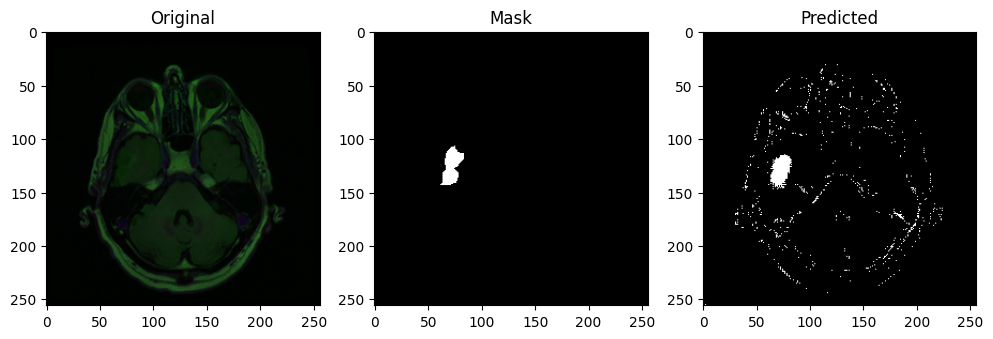

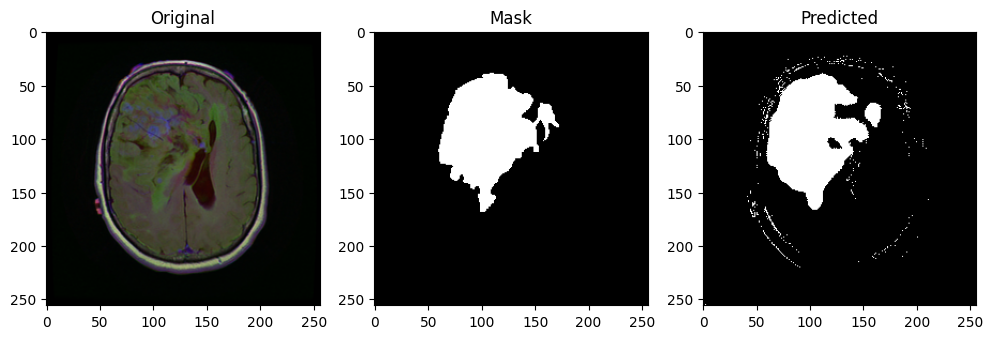

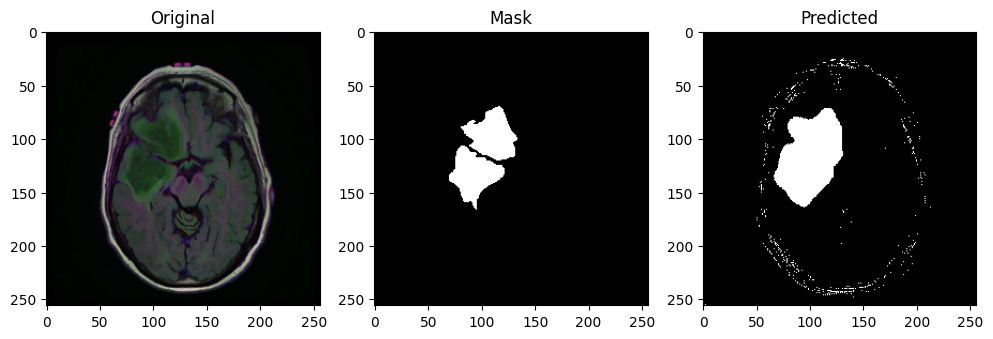

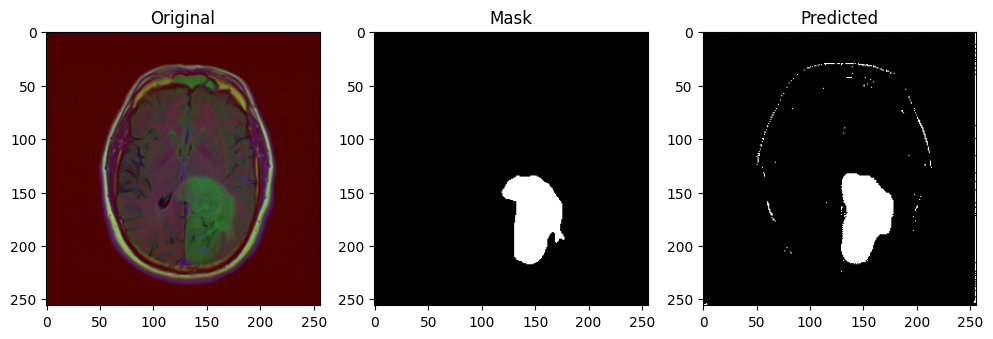

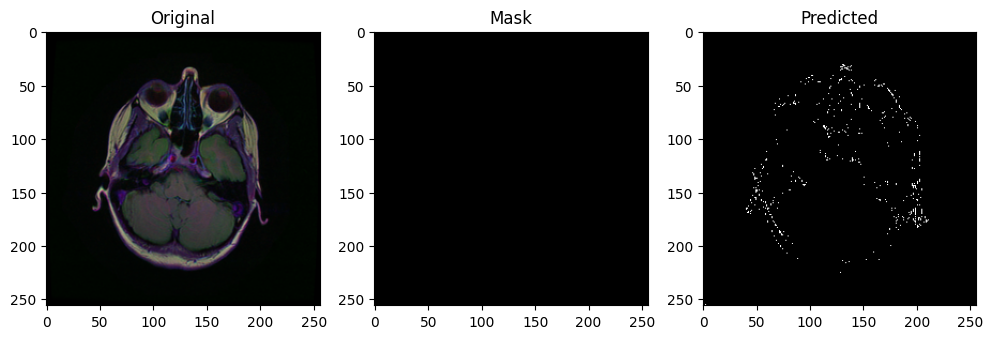

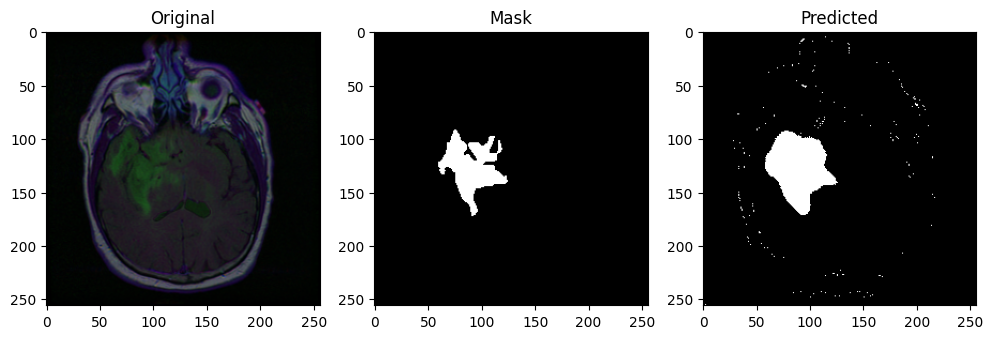

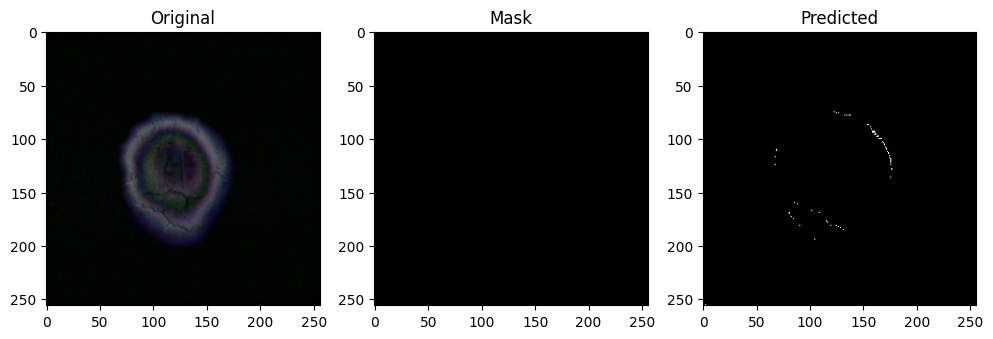

In [21]:
for index in range(0 , 10):
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1 , 3 , 1)
    plt.title('Original')
    img = cv.cvtColor(X_test[index] , cv.COLOR_BGR2RGB)
    plt.imshow(img)

    plt.subplot(1 , 3  ,2)
    plt.title('Mask')
    plt.imshow(y_test[index].squeeze() , cmap = 'gray')

    plt.subplot(1 , 3 , 3)
    plt.title('Predicted')
    plt.imshow(predict_mask[index].squeeze() , cmap = 'gray')
    
    plt.show()

In [22]:
img_path = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14.tif'

In [23]:
def predict_mask(img_path):
    img = cv.imread(img_path)
    if img is None:
        print(f"❌ Couldn't read image at {img_path}")
        return
    
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, (H, W))  
    img_input = img / 255.0  
    img_input = np.expand_dims(img_input, axis=0)

    pred = model.predict(img_input)[0]
    pred_mask = (pred > 0.5).astype(np.uint8) 

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Input Image")
    plt.imshow(img)

    plt.subplot(1,2,2)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask.squeeze(), cmap='gray')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


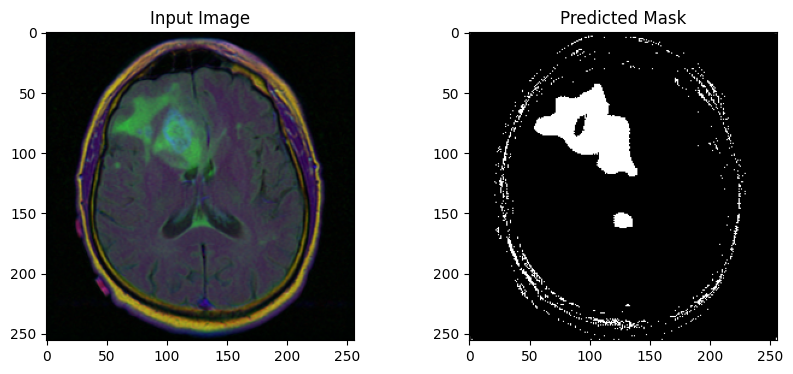

In [24]:
predict_mask(img_path)

In [25]:
model.save("brain_tumor_segmentation_model.keras")

In [26]:
from tensorflow.keras.models import load_model

model = load_model("brain_tumor_segmentation_model.keras")

In [27]:
from IPython.display import FileLink
FileLink("brain_tumor_segmentation_model.keras")

/kaggle/working/brain_tumor_segmentation_model.keras